# Data Acquisition

In [ ]:
from pathlib import Path
import pandas as pd

# from google.colab import drive
# drive.mount('/content/drive')

DRIVE_ROOT = Path("/content/drive/MyDrive")
DATA_DIR   = DRIVE_ROOT / "Capstone Dataset"          # dataset folder
PROJ_DIR   = DRIVE_ROOT / "project"                   # workspace for outputs

# Minimal folders (figures/tables/logs/summaries)
for p in [
    PROJ_DIR,
    PROJ_DIR / "reports" / "figures",
    PROJ_DIR / "reports" / "tables",
    PROJ_DIR / "reports" / "logs",
    PROJ_DIR / "reports" / "summaries",
]:
    p.mkdir(parents=True, exist_ok=True)

print("DATA_DIR:", DATA_DIR)
print("PROJ_DIR:", PROJ_DIR)

# Tiny in-notebook config
CFG = {
    "FACTORS_CSV":  DATA_DIR / "FACTors.csv",
    "AUTHORS_CSV":  DATA_DIR / "author_stats.csv",
    "ORGS_CSV":     DATA_DIR / "org_stats.csv",
    "CLEAN_CSV":    PROJ_DIR / "reports" / "tables" / "FACTors_clean.csv",
    "COLS": {
        "row_id": "row_id",
        "report_id": "report_id",
        "claim_id": "claim_id",
        "claim": "claim",
        "content": "content",
        "date_published": "date_published",
        "author": "author",
        "organisation": "organisation",
        "original_verdict": "original_verdict",
        "title": "title",
        "url": "url",
        "normalised_rating": "normalised_rating",
    }
}


DATA_DIR: /content/drive/MyDrive/Capstone Dataset
PROJ_DIR: /content/drive/MyDrive/project


In [ ]:
df_raw = pd.read_csv(CFG["FACTORS_CSV"])
print("FACTors shape:", df_raw.shape)
print("FACTors columns:", list(df_raw.columns)[:15])
df_raw.head()

FACTors shape: (118112, 11)
FACTors columns: ['row_id', 'article_id', 'claim_id', 'claim', 'date_published', 'author', 'organisation', 'original_verdict', 'title', 'url', 'normalised_rating']


,row_id,article_id,claim_id,claim,date_published,author,organisation,original_verdict,title,url,normalised_rating
0,1,49808,2977,"""Allahu Akbar"" has replaced"" Cheerio, mate!"" a...",2024-12-12T00:00:00,Soofia Tariq,Australian Associated Press,false. the claim originated on a satire website.,"No, 'Allahu Akbar' hasn't become most popular ...",https://www.aap.com.au/factcheck/no-allahu-akb...,false
1,2,49837,1828,Elon Musk has announced a Tesla mobile phone.,2024-12-12T00:00:00,William Summers,Australian Associated Press,false. mr musk said in november 2024 that the ...,"No, Elon Musk has not announced a Tesla mobile...",https://www.aap.com.au/factcheck/no-elon-musk-...,false
2,3,49532,2978,"It takes 30,000 tonnes of concrete and 30,000 ...",2024-12-13T00:00:00,George Driver,Australian Associated Press,false. experts and industry representatives sa...,Geologist wrong to claim wind turbines need 30...,https://www.aap.com.au/factcheck/geologist-wro...,false
3,4,50339,2979,A video reveals the slain UnitedHealthcare CEO...,2024-12-13T00:00:00,Blair Wise,Australian Associated Press,false. the man in the video is a different per...,UnitedHealthcare CEO shooting sparks slew of c...,https://www.aap.com.au/factcheck/unitedhealthc...,false
4,5,49038,2980,Prime Minister Anthony Albanese is promoting a...,2024-11-22T00:00:00,George Driver,Australian Associated Press,false. it's a scam and the video of mr albanes...,Anthony Albanese video manipulated in AI scam,https://www.aap.com.au/factcheck/anthony-alban...,false


In [ ]:
df_auth_stats = pd.read_csv(CFG["AUTHORS_CSV"])
print("author_stats shape:", df_auth_stats.shape)
df_auth_stats.head(3)

author_stats shape: (1953, 11)


,author,experience_days,number_of_fact_checks,unique_claim_percentage,fc_frequency_mean,fc_frequency_std,pairwise_diff_mean,pairwise_diff_std,number_of_organisations,word_count_mean,word_count_std
0,Anoushka Rajesh,0,1,0.0,NaN,NaN,NaN,NaN,1,564.0,NaN
1,Binit Priyaranjan,0,1,1.0,NaN,NaN,NaN,NaN,1,1185.0,NaN
2,Darab Mansoor Ali,0,1,1.0,NaN,NaN,NaN,NaN,1,243.0,NaN


In [ ]:
df_org_stats = pd.read_csv(CFG["ORGS_CSV"])
print("org_stats shape:", df_org_stats.shape)
df_org_stats.head(3)

org_stats shape: (39, 13)


,organisation,country,url,experience_days,number_of_fact_checks,unique_claim_percentage,fc_frequency_mean,fc_frequency_std,pairwise_diff_mean,pairwise_diff_std,number_of_authors,word_count_mean,word_count_std
0,AAP,Australia,https://www.aap.com.au/,1960,1474,0.924387,1.330618,3.827460,591.080066,424.885321,47,699.585482,218.064687
1,AFP Fact Check,France,https://www.afp.com/en,2097,11799,0.931936,0.046364,0.286102,677.112335,488.339587,458,472.035257,871.986472
2,Africa Check,South Africa,https://africacheck.org/,4510,6316,0.984318,0.714173,1.616213,1039.228893,841.815099,256,448.365104,374.368664


# Data Cleaning



In [ ]:
!pip -q install langdetect nltk sentence-transformers

import re
from pathlib import Path
from datetime import datetime

import langdetect
import pandas as pd
from nltk import word_tokenize
from sentence_transformers import SentenceTransformer

# making sure NLTK tokenizer data is available
import nltk
nltk.download("punkt", quiet=True)

RAW_CSV   = CFG["FACTORS_CSV"]
CLEAN_CSV = CFG["CLEAN_CSV"]
phrase_file = DATA_DIR / "redundant_phrases.txt"  # making sure this file is here

print("Reading raw FACTors from:", RAW_CSV)
df = pd.read_csv(RAW_CSV)

# Convenience aliases
C = CFG["COLS"]

Reading raw FACTors from: /content/drive/MyDrive/Capstone Dataset/FACTors.csv


In [ ]:
def detect_lang(text: str) -> str:
    """Language code (or '?') using langdetect."""
    try:
        return langdetect.detect(str(text))
    except Exception:
        return "?"


def has_enough_letters(text: str, min_chars: int = 10) -> bool:
    """Check content has letters and minimum length."""
    text = str(text)
    return bool(re.search(r"[A-Za-z]", text)) and len(text) > min_chars


def clean_whitespace(text: str) -> str:
    if not isinstance(text, str):
        return text
    text = text.replace("\u200b", "").replace("\ufeff", "")
    text = re.sub(r"\s+", " ", text).strip()
    return text


def normalize_quotes(text: str) -> str:
    """Convert smart quotes to plain quotes."""
    if not isinstance(text, str):
        return text
    repl = {
        "“": '"', "”": '"',
        "‘": "'", "’": "'",
    }
    return "".join(repl.get(ch, ch) for ch in text)


def try_parse_date(text):
    """Parse date to ISO string if possible, else return None."""
    if pd.isna(text):
        return None
    s = str(text).strip()
    # fi already ISO-like, using pandas
    try:
        dt = pd.to_datetime(s, utc=True, errors="coerce")
        if pd.isna(dt):
            return None
        return dt.isoformat()
    except Exception:
        return None

In [ ]:
# Language filtering (content + title both English)

print("Language filtering...")

# detecting language using CLAIM and TITLE
df["lang_claim"] = df[C["claim"]].apply(detect_lang)
df["lang_title"] = df[C["title"]].apply(detect_lang)

before_lang = len(df)

# keeping only rows where both claim and title are English
df = df[(df["lang_claim"] == "en") & (df["lang_title"] == "en")].copy()

df.drop(columns=["lang_claim", "lang_title"], inplace=True)

print(f" - Before: {before_lang}, after EN filter: {len(df)}")


Language filtering...
 - Before: 118112, after EN filter: 115988


In [ ]:
# handling missing / weak content, claim, author

print("Handling missing / short content, claim, author...")

# replacing bad/short claims with title text
def fix_claim(row):
    c = str(row[C["claim"]]) if pd.notna(row[C["claim"]]) else ""
    c = c.strip()
    if len(c) < 10 or c.lower() == "no claim found":
        return row[C["title"]]
    return c

df[C["claim"]] = df.apply(fix_claim, axis=1)

# normalizing author: blank -> "Unknown"
df[C["author"]] = df[C["author"]].apply(
    lambda x: "Unknown" if not str(x).strip() else str(x).strip()
)

# dropping rows with missing critical fields
needed_cols = [C["title"], C["url"], C["date_published"], C["claim"], C["original_verdict"]]
df = df.dropna(subset=needed_cols)
print(f"After missing-value cleanup: {len(df)} rows")

Handling missing / short content, claim, author...
After missing-value cleanup: 115988 rows


In [ ]:
# dates, quotes, and simple text cleaning

print("Normalizing dates & basic text cleanup...")

df[C["date_published"]] = df[C["date_published"]].apply(try_parse_date)
df = df.dropna(subset=[C["date_published"]])
df[C["date_published"]] = pd.to_datetime(df[C["date_published"]], utc=True)

for col in [C["claim"], C["title"], C["author"], C["organisation"], C["original_verdict"]]:
    if col in df.columns:
        df[col] = df[col].astype(str).map(normalize_quotes).map(clean_whitespace)


# for multi-author strings like "Name1, Name2"
df[C["author"]] = df[C["author"]].apply(
    lambda s: ";".join([part.strip() for part in str(s).replace('"', "").split(",") if part.strip()])
)

Normalizing dates & basic text cleanup...


In [ ]:
# removing redundant phrases from claim/verdict

print("Removing redundant phrases from claim/verdict...")

if phrase_file.exists():
    with open(phrase_file, "r", encoding="utf-16") as f:
        phrases = [line.strip() for line in f if line.strip()]
    if phrases:
        pattern = re.compile("|".join(re.escape(p) for p in phrases), flags=re.IGNORECASE)

        def strip_phrases(text: str) -> str:
            return clean_whitespace(pattern.sub("", str(text)))

        df[C["claim"]]          = df[C["claim"]].map(strip_phrases)
        df[C["original_verdict"]] = df[C["original_verdict"]].map(strip_phrases)
        print(f"Removed {len(phrases)} known template phrases")
else:
    print("No redundant_phrases.txt found; skipping phrase removal")

Removing redundant phrases from claim/verdict...
No redundant_phrases.txt found; skipping phrase removal


In [ ]:
# simple duplicate removal

print("Removing obvious duplicates...")

before_dup = len(df)
df = df.drop_duplicates()

if {C["claim"], C["organisation"], C["date_published"]}.issubset(df.columns):
    df = df.sort_values(C["date_published"]).drop_duplicates(
        subset=[C["claim"], C["organisation"], C["date_published"]], keep="first"
    )
after_dup = len(df)
print(f"Before dedup: {before_dup}, after dedup: {after_dup}")

Removing obvious duplicates...
Before dedup: 115988, after dedup: 115988


In [ ]:
# saving cleaned dataset

df.to_csv(CLEAN_CSV, index=False)
print("\nSaved cleaned FACTors to:", CLEAN_CSV)


Saved cleaned FACTors to: /content/drive/MyDrive/project/reports/tables/FACTors_clean.csv


# Exploratory Data Analysis (EDA)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C = CFG["COLS"]
FIG_DIR = PROJ_DIR / "reports" / "figures"

df = pd.read_csv(CFG["CLEAN_CSV"], parse_dates=[C["date_published"]])

def save_fig(fig, name):
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    out = FIG_DIR / name
    fig.savefig(out, dpi=160, bbox_inches="tight")
    plt.show(); plt.close(fig)
    print("Saved:", out)

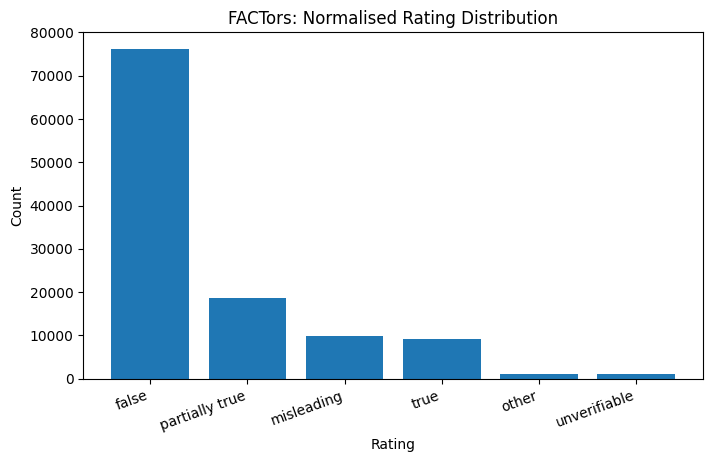

Saved: /content/drive/MyDrive/project/reports/figures/w1_labels_distribution.png


In [ ]:
# class distribution
label_counts = df[C["normalised_rating"]].value_counts().sort_values(ascending=False)
fig = plt.figure(figsize=(8,4.5))
plt.bar(label_counts.index, label_counts.values)
plt.title("FACTors: Normalised Rating Distribution")
plt.xlabel("Rating"); plt.ylabel("Count")
plt.xticks(rotation=20, ha="right")
save_fig(fig, "w1_labels_distribution.png")

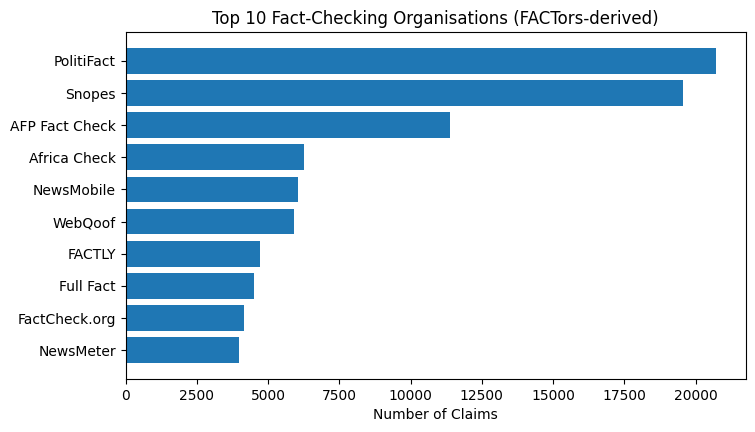

Saved: /content/drive/MyDrive/project/reports/figures/w1_top10_organisations_FACTors.png


In [ ]:
# Top 10 organisations
org_counts = df[C["organisation"]].value_counts().head(10)[::-1]
fig = plt.figure(figsize=(8,4.5))
plt.barh(org_counts.index, org_counts.values)
plt.title("Top 10 Fact-Checking Organisations (FACTors-derived)")
plt.xlabel("Number of Claims")
save_fig(fig, "w1_top10_organisations_FACTors.png")

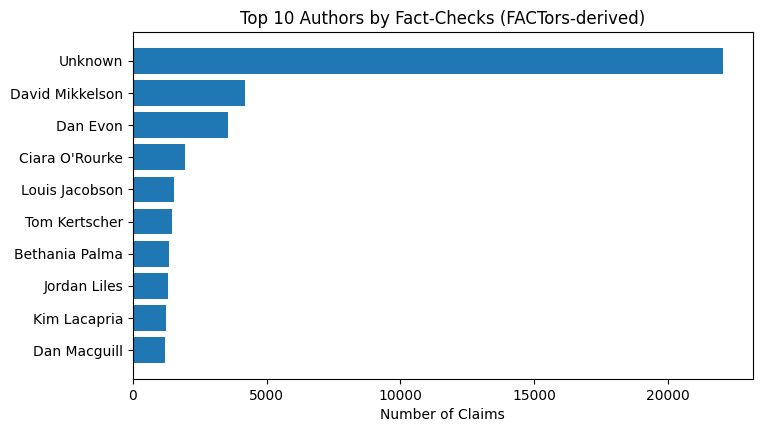

Saved: /content/drive/MyDrive/project/reports/figures/w1_top10_authors_FACTors.png


In [ ]:
# Top 10 authors (from FACTors)
author_counts = df[C["author"]].value_counts().head(10)[::-1]
fig = plt.figure(figsize=(8,4.5))
plt.barh(author_counts.index, author_counts.values)
plt.title("Top 10 Authors by Fact-Checks (FACTors-derived)")
plt.xlabel("Number of Claims")
save_fig(fig, "w1_top10_authors_FACTors.png")

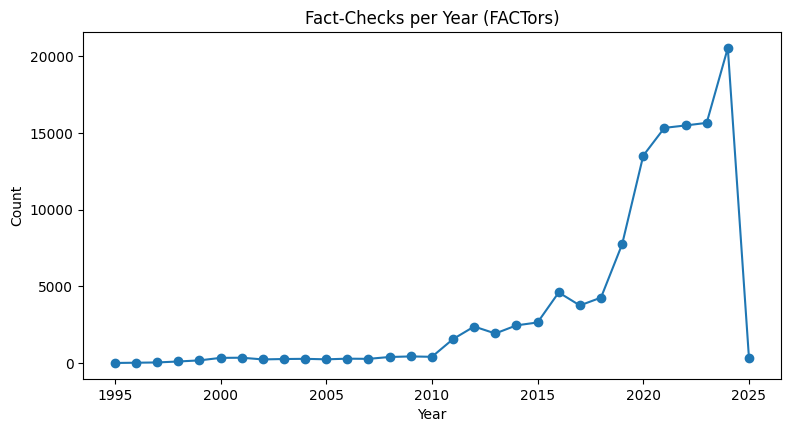

Saved: /content/drive/MyDrive/project/reports/figures/w1_yearly_trend.png


In [ ]:
# Yearly trend
year_counts = df[C["date_published"]].dt.year.value_counts().sort_index()
fig = plt.figure(figsize=(9,4.5))
plt.plot(year_counts.index, year_counts.values, marker="o")
plt.title("Fact-Checks per Year (FACTors)")
plt.xlabel("Year"); plt.ylabel("Count")
save_fig(fig, "w1_yearly_trend.png")

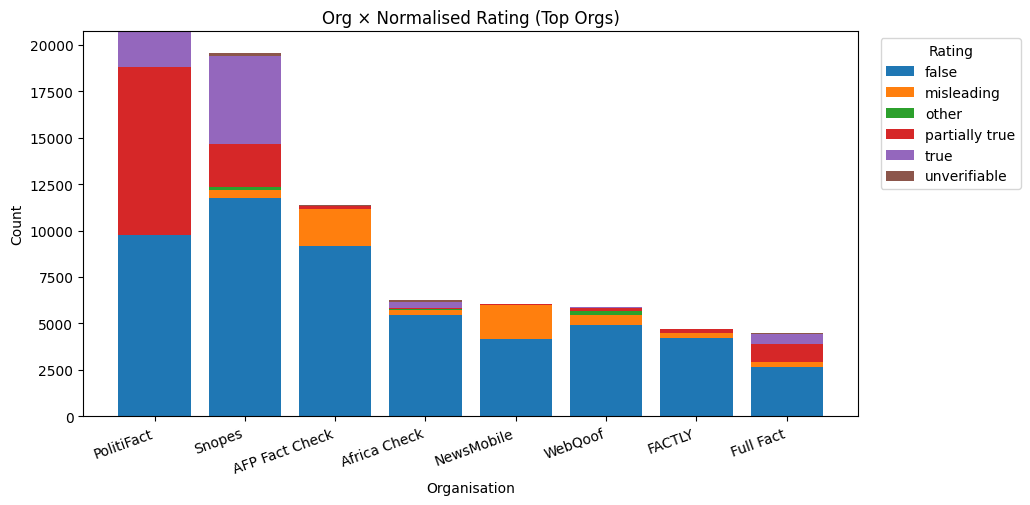

Saved: /content/drive/MyDrive/project/reports/figures/w1_org_by_rating_stacked.png


In [ ]:
# Org × Rating stacked bars
TOPN = 8
top_orgs = df[C["organisation"]].value_counts().head(TOPN).index.tolist()
dft = df[df[C["organisation"]].isin(top_orgs)]
ctab = pd.crosstab(dft[C["organisation"]], dft[C["normalised_rating"]])
ctab = ctab.reindex(index=top_orgs)
fig = plt.figure(figsize=(10,5))
bottom = np.zeros(len(ctab))
for col in ctab.columns:
    plt.bar(ctab.index, ctab[col].values, bottom=bottom, label=col)
    bottom += ctab[col].values
plt.title("Org × Normalised Rating (Top Orgs)")
plt.xlabel("Organisation"); plt.ylabel("Count")
plt.xticks(rotation=20, ha="right")
plt.legend(title="Rating", bbox_to_anchor=(1.02, 1), loc="upper left")
save_fig(fig, "w1_org_by_rating_stacked.png")

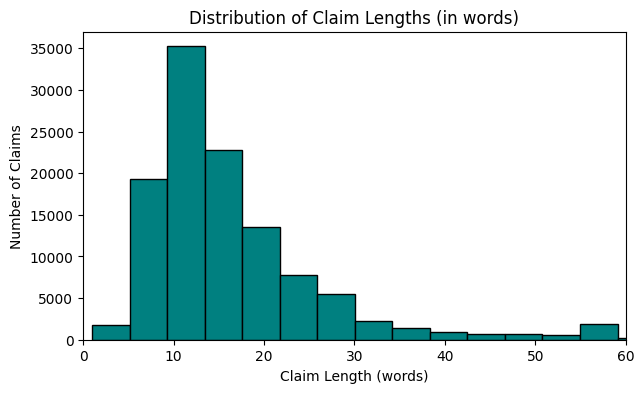

Saved: /content/drive/MyDrive/project/reports/figures/w1_hist_claim_length.png


In [ ]:
# Claim lengths (word count)
df["claim_len"] = df[C["claim"]].fillna("").apply(lambda x: len(str(x).split()))
fig = plt.figure(figsize=(7,4))
plt.hist(df["claim_len"], bins=40, color="teal", edgecolor="black")
plt.title("Distribution of Claim Lengths (in words)")
plt.xlabel("Claim Length (words)")
plt.ylabel("Number of Claims")
plt.xlim(0, 60)
save_fig(fig, "w1_hist_claim_length.png")

# Preprocessing and Temporal Splits

In [ ]:
from pathlib import Path
import json
import pandas as pd
import numpy as np

CLEAN_CSV  = CFG["CLEAN_CSV"]
TAB_DIR    = PROJ_DIR / "reports" / "tables"
ART_DIR    = PROJ_DIR / "models" / "artifacts"
for p in [TAB_DIR, ART_DIR]:
    p.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(CLEAN_CSV, parse_dates=[CFG["COLS"]["date_published"]])

text_col  = CFG["COLS"]["claim"]
orig_label_col = CFG["COLS"]["normalised_rating"]

In [ ]:
# normalizing labels + merging "Misleading" into "Partially True"

def normalize_label_str(x: str) -> str:
    if not isinstance(x, str):
        return x
    s = x.strip().lower()
    if s == "misleading":
        return "partially true"
    return s

df[orig_label_col] = df[orig_label_col].astype(str).map(normalize_label_str)

# for neatness in plots, using Title Case
df[orig_label_col] = df[orig_label_col].str.title()

# dropping rows with missing label or text
df = df.dropna(subset=[text_col, orig_label_col])

In [ ]:
# creating year column and temporal splits

date_col = CFG["COLS"]["date_published"]
df["year"] = pd.to_datetime(df[date_col], utc=True, errors="coerce").dt.year
df = df.dropna(subset=["year"])

train_df = df[df["year"] <= 2022].copy()
val_df   = df[df["year"] == 2023].copy()
test_df  = df[df["year"] >= 2024].copy()

print("Split sizes:", len(train_df), "train /", len(val_df), "val /", len(test_df), "test")

Split sizes: 79444 train / 15660 val / 20884 test


In [ ]:
# label mapping after merge

labels = sorted(df[orig_label_col].unique().tolist())
label2id = {lbl: i for i, lbl in enumerate(labels)}
id2label = {i: lbl for lbl, i in label2id.items()}

for part in (train_df, val_df, test_df):
    part["label_id"] = part[orig_label_col].map(label2id).astype(int)

with open(ART_DIR / "label_mapping.json", "w") as f:
    json.dump({"label2id": label2id, "id2label": id2label}, f, indent=2)

In [ ]:
# saving split CSVs

cols_common = ["year", text_col, orig_label_col, "label_id"]

train_df.assign(split="train")[cols_common + ["split"]].to_csv(TAB_DIR / "split_train.csv", index=False)
val_df.assign(split="val")[cols_common + ["split"]].to_csv(TAB_DIR / "split_val.csv", index=False)
test_df.assign(split="test")[cols_common + ["split"]].to_csv(TAB_DIR / "split_test.csv", index=False)

summary = pd.DataFrame({
    "split": ["train","val","test"],
    "rows": [len(train_df), len(val_df), len(test_df)]
})
summary.to_csv(TAB_DIR / "splits_summary.csv", index=False)

print("Label -> id mapping:", label2id)
print("Saved splits & mapping in:", TAB_DIR, "and", ART_DIR)



Label → id mapping: {'False': 0, 'Other': 1, 'Partially True': 2, 'True': 3, 'Unverifiable': 4}
Saved splits & mapping in: /content/drive/MyDrive/project/reports/tables and /content/drive/MyDrive/project/models/artifacts


# Training DeBERTa Baseline


In [ ]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
import time

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModel

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, confusion_matrix
)

# Paths
DRIVE_ROOT = Path("/content/drive/MyDrive")
PROJ_DIR   = DRIVE_ROOT / "project"
TAB_DIR  = PROJ_DIR / "reports" / "tables"
ART_DIR  = PROJ_DIR / "models" / "artifacts"
CKPT_DIR = PROJ_DIR / "models" / "checkpoints" / "deberta_v1"
CKPT_DIR.mkdir(parents=True, exist_ok=True)

# loading splits + label mapping
train_df = pd.read_csv(TAB_DIR / "split_train.csv")
val_df   = pd.read_csv(TAB_DIR / "split_val.csv")

with open(ART_DIR / "label_mapping.json") as f:
    mm = json.load(f)
label2id = mm["label2id"]
id2label = {int(k): v for k, v in mm["id2label"].items()}
num_labels = len(label2id)

print("Classes:", id2label)

Classes: {0: 'False', 1: 'Other', 2: 'Partially True', 3: 'True', 4: 'Unverifiable'}


In [ ]:
# Tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 6
LR = 3e-5

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
# YEAR NORMALIZATION -> map year to integer index
all_years = sorted(train_df["year"].unique().tolist() + val_df["year"].unique().tolist())
year2id = {y:i for i,y in enumerate(all_years)}
num_year_ids = len(year2id)

train_df["year_id"] = train_df["year"].map(year2id)
val_df["year_id"]   = val_df["year"].map(year2id)

with open(ART_DIR / "year_mapping.json", "w") as f:
    json.dump({"year2id": year2id}, f, indent=2)

In [ ]:
# DATASET CLASS (TEXT + YEAR EMBEDDING)
class ClaimsDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.texts = df["claim"].tolist()
        self.labels = df["label_id"].tolist()
        self.year_ids = df["year_id"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(int(self.labels[idx]), dtype=torch.long),
            "year_id": torch.tensor(int(self.year_ids[idx]), dtype=torch.long),
        }

train_dataset = ClaimsDataset(train_df, tokenizer, MAX_LEN)
val_dataset   = ClaimsDataset(val_df, tokenizer, MAX_LEN)

In [ ]:
# OVERSAMPLING (WeightedRandomSampler)
labels_np = train_df["label_id"].to_numpy()
counts = np.bincount(labels_np, minlength=num_labels)
inv_freq = 1 / np.maximum(counts, 1)
sample_weights = torch.tensor([inv_freq[y] for y in labels_np], dtype=torch.float)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)

print("Class counts:", counts)
print("Oversampling weights:", inv_freq)

Class counts: [48820   765 21896  7441   522]
Oversampling weights: [2.04834084e-05 1.30718954e-03 4.56704421e-05 1.34390539e-04
 1.91570881e-03]


In [ ]:
# MODEL (DeBERTa-v3 + YEAR EMBEDDING)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# loading DeBERTa-v3 encoder
encoder = AutoModel.from_pretrained(model_name)
encoder = encoder.float().to(device)

hidden_size = encoder.config.hidden_size  # 768 for v3-base

class DebertaWithYear(nn.Module):
    def __init__(self, encoder, num_labels, num_year_ids, year_emb_dim=32):
        super().__init__()
        self.encoder = encoder
        self.year_emb = nn.Embedding(num_year_ids, year_emb_dim)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_size + year_emb_dim, num_labels)

    def forward(self, input_ids, attention_mask, year_id):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:,0,:]    # CLS embedding
        yemb = self.year_emb(year_id)
        combined = torch.cat([cls, yemb], dim=1)
        combined = self.dropout(combined)
        logits = self.classifier(combined)
        return logits

model = DebertaWithYear(
    encoder=encoder,
    num_labels=num_labels,
    num_year_ids=num_year_ids,
    year_emb_dim=32
).to(device)

Using device: cuda


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

In [ ]:
# FOCAL LOSS (Better for imbalance)
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction="none")

    def forward(self, logits, labels):
        ce_loss = self.ce(logits, labels)
        pt = torch.softmax(logits, dim=1).gather(1, labels.unsqueeze(1)).squeeze()
        focal = (1 - pt) ** self.gamma * ce_loss
        return focal.mean()

criterion = FocalLoss(gamma=2.0)
optimizer = AdamW(model.parameters(), lr=LR)

In [ ]:
# EVALUATION
def compute_ece(probs, labels, n_bins=15):
    confidences = probs.max(axis=1)
    predictions = probs.argmax(axis=1)
    correct = (predictions == labels).astype(float)

    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (confidences > lo) & (confidences <= hi)
        if mask.sum() == 0:
            continue
        ece += mask.mean() * abs(correct[mask].mean() - confidences[mask].mean())

    return float(ece)

def evaluate(model, loader):
    model.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            ids = batch["input_ids"].to(device)
            mask= batch["attention_mask"].to(device)
            yid = batch["year_id"].to(device)
            labels = batch["labels"].to(device)

            logits = model(ids, mask, yid)
            all_logits.append(logits.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_logits = np.concatenate(all_logits)
    all_labels = np.concatenate(all_labels)
    probs = torch.softmax(torch.tensor(all_logits), dim=-1).numpy()
    preds = all_logits.argmax(axis=-1)

    return {
        "accuracy": accuracy_score(all_labels, preds),
        "macro_f1": f1_score(all_labels, preds, average="macro"),
        "macro_precision": precision_score(all_labels, preds, average="macro", zero_division=0),
        "macro_recall": recall_score(all_labels, preds, average="macro", zero_division=0),
        "ece": compute_ece(probs, all_labels),
        "confusion_matrix": confusion_matrix(all_labels, preds),
    }

In [ ]:
# TRAINING LOOP

def format_time(seconds):
    """Convert seconds → hh:mm:ss"""
    m, s = divmod(int(seconds), 60)
    h, m = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

print("Starting Training...\n")

total_training_start = time.time()

for epoch in range(1, EPOCHS + 1):
    epoch_start = time.time()

    print(f"\n==== Epoch {epoch}/{EPOCHS} ==== (Estimated time: calculating...)")

    model.train()
    total_loss = 0.0

    for step, batch in enumerate(train_loader, start=1):

        optimizer.zero_grad()

        ids  = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        yid  = batch["year_id"].to(device)
        lbls = batch["labels"].to(device)

        logits = model(ids, mask, yid)
        loss   = criterion(logits, lbls)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # ---- Print batch progress every 50 steps ----
        if step % 50 == 0:
            print(f"  Step {step}, batch loss = {loss.item():.4f}")

    # ---- End of epoch timing ----
    epoch_time = time.time() - epoch_start
    time_left = (EPOCHS - epoch) * epoch_time

    print(f"\nEpoch {epoch}/{EPOCHS} completed.")
    print(f"  Average train loss: {total_loss/len(train_loader):.4f}")
    print(f"  Epoch time: {format_time(epoch_time)}")
    print(f"  Estimated remaining time: {format_time(time_left)}")

    # Validation
    val = evaluate(model, val_loader)

    print(
        f"  [VAL] acc={val['accuracy']:.4f}, "
        f"f1={val['macro_f1']:.4f}, "
        f"prec={val['macro_precision']:.4f}, "
        f"rec={val['macro_recall']:.4f}, "
        f"ece={val['ece']:.4f}"
    )


# model_save_dir = CKPT_DIR / "final_model"
# model_save_dir.mkdir(parents=True, exist_ok=True)

# torch.save(model.state_dict(), model_save_dir / "model.pt")
# tokenizer.save_pretrained(model_save_dir)

# print("\nSaved model + tokenizer →", model_save_dir)

Starting Training...


==== Epoch 1/6 ==== (Estimated time: calculating...)
  Step 50, batch loss = 0.1452
  Step 100, batch loss = 0.2307
  Step 150, batch loss = 0.2760
  Step 200, batch loss = 0.2963
  Step 250, batch loss = 0.1308
  Step 300, batch loss = 0.2255
  Step 350, batch loss = 0.3155
  Step 400, batch loss = 0.3157
  Step 450, batch loss = 0.2513
  Step 500, batch loss = 0.3964
  Step 550, batch loss = 0.2057
  Step 600, batch loss = 0.3313
  Step 650, batch loss = 0.4873
  Step 700, batch loss = 0.2921
  Step 750, batch loss = 0.5486
  Step 800, batch loss = 0.2679
  Step 850, batch loss = 0.1232
  Step 900, batch loss = 0.3938
  Step 950, batch loss = 0.1185
  Step 1000, batch loss = 0.3191
  Step 1050, batch loss = 0.3834
  Step 1100, batch loss = 0.2535
  Step 1150, batch loss = 0.2727
  Step 1200, batch loss = 0.1611
  Step 1250, batch loss = 0.3196
  Step 1300, batch loss = 0.1853
  Step 1350, batch loss = 0.2254
  Step 1400, batch loss = 0.2490
  Step 1450, batch l

In [ ]:
model_save_dir = CKPT_DIR / "final_model"
model_save_dir.mkdir(parents=True, exist_ok=True)

# saving model in HF format
# HF expects: pytorch_model.bin + config.json
torch.save(model.state_dict(), model_save_dir / "pytorch_model.bin")

# saving config
model_config = {
    "model_type": "deberta-v3",
    "hidden_size": encoder.config.hidden_size,
    "num_labels": num_labels,
    "year_emb_dim": 32,
    "num_year_ids": num_year_ids,
}
import json
with open(model_save_dir / "config.json", "w") as f:
    json.dump(model_config, f, indent=2)

# saving TOKENIZER
tokenizer.save_pretrained(model_save_dir)

print("Saved model + tokenizer →", model_save_dir)


Saved model + tokenizer → /content/drive/MyDrive/project/models/checkpoints/deberta_v3_final/final_model


In [ ]:
# SAVE MODEL + METRICS
metrics = {
    "val_accuracy": val["accuracy"],
    "val_macro_f1": val["macro_f1"],
    "val_macro_precision": val["macro_precision"],
    "val_macro_recall": val["macro_recall"],
    "val_ece": val["ece"],
}
pd.Series(metrics).to_csv(TAB_DIR / "w2_val_metrics.csv")

cm = val["confusion_matrix"]
pd.DataFrame(
    cm,
    index=[f"true_{id2label[i]}" for i in range(num_labels)],
    columns=[f"pred_{id2label[i]}" for i in range(num_labels)]
).to_csv(TAB_DIR / "w2_val_confusion_matrix.csv")

# model_save_dir = CKPT_DIR / "final_model"
# model_save_dir.mkdir(parents=True, exist_ok=True)

# torch.save(model.state_dict(), model_save_dir / "model.pt")
# tokenizer.save_pretrained(model_save_dir)

# print("\nSaved model + tokenizer →", model_save_dir)

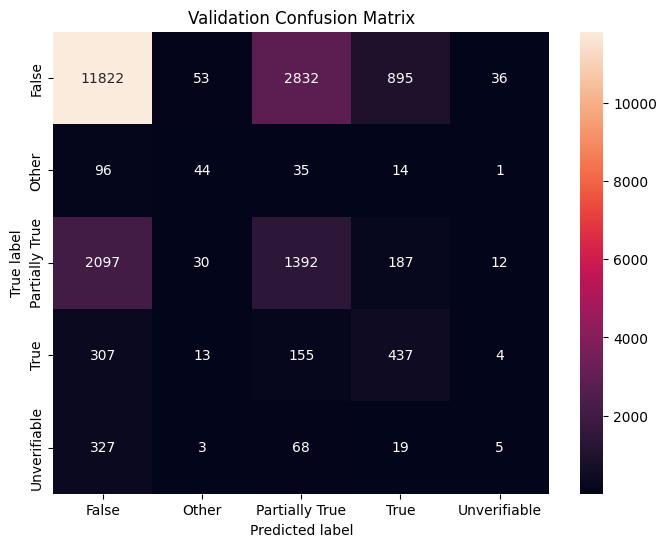

Saved: /content/drive/MyDrive/project/reports/figures/w2_val_confusion_matrix.png


In [ ]:
def plot_confusion_matrix_seaborn(cm, id2label, num_labels, title="Validation Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(8, 6))

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=[id2label[i] for i in range(num_labels)],
        yticklabels=[id2label[i] for i in range(num_labels)],
        ax=ax
    )

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(title)

    return fig

fig = plot_confusion_matrix_seaborn(cm, id2label, num_labels)
save_fig(fig, "w2_val_confusion_matrix.png")


In [ ]:
metrics

{'val_accuracy': 0.6728607918263091,
 'val_macro_f1': 0.4058032408445957,
 'val_macro_precision': 0.39822194771721475,
 'val_macro_recall': 0.4310372001147888,
 'val_ece': 0.018740809700269825}

# Testing

In [ ]:
!pip -q install transformers scikit-learn sentencepiece

import json
import numpy as np
import pandas as pd
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
)

TAB_DIR  = PROJ_DIR / "reports" / "tables"
ART_DIR  = PROJ_DIR / "models" / "artifacts"
CKPT_DIR = PROJ_DIR / "models" / "checkpoints" / "deberta_v3_final"
MODEL_DIR = CKPT_DIR / "final_model"

In [ ]:
# loading test split & mappings
test_df = pd.read_csv(TAB_DIR / "split_test.csv")

with open(ART_DIR / "label_mapping.json") as f:
    mm = json.load(f)
label2id = mm["label2id"]
id2label = {int(k): v for k,v in mm["id2label"].items()}
num_labels = len(label2id)

with open(ART_DIR / "year_mapping.json") as f:
    ym = json.load(f)
year2id = ym["year2id"]
year2id = {int(k): int(v) for k,v in year2id.items()}
num_year_ids = len(year2id)

In [ ]:
# mapping test years to year_id (fallback to last id if unseen)
def map_year(y):
    y_int = int(y)
    if str(y_int) in year2id:
        return year2id[str(y_int)]
    # unseen year: mapping to a special "last" bucket
    return max(year2id.values())  # safe fallback

test_df["year_id"] = test_df["year"].apply(map_year)

In [ ]:
# Tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(
    str(MODEL_DIR),
    local_files_only=True
)

MAX_LEN = 256
BATCH_SIZE = 32

# loading config
with open(MODEL_DIR / "config.json") as f:
    cfg = json.load(f)

hidden_size = cfg["hidden_size"]
year_emb_dim = cfg["year_emb_dim"]
num_year_ids = cfg["num_year_ids"]

In [ ]:
# Dataset
class ClaimsDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.texts = df["claim"].tolist()
        self.labels = df["label_id"].tolist()
        self.year_ids = df["year_id"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(int(self.labels[idx]), dtype=torch.long),
            "year_id": torch.tensor(int(self.year_ids[idx]), dtype=torch.long),
        }

test_dataset = ClaimsDataset(test_df, tokenizer, MAX_LEN)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

encoder = AutoModel.from_pretrained(
    model_name,
    local_files_only=False
).to(device)
encoder = encoder.float().to(device)
hidden_size = encoder.config.hidden_size  # 768

class DebertaWithYear(nn.Module):
    def __init__(self, encoder, num_labels, num_year_ids, year_emb_dim=32):
        super().__init__()
        self.encoder = encoder
        self.year_emb = nn.Embedding(num_year_ids, year_emb_dim)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_size + year_emb_dim, num_labels)

    def forward(self, input_ids, attention_mask, year_id):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]
        yemb = self.year_emb(year_id)
        combined = torch.cat([cls, yemb], dim=1)
        combined = self.dropout(combined)
        logits = self.classifier(combined)
        return logits

model = DebertaWithYear(
    encoder=encoder,
    num_labels=num_labels,
    num_year_ids=num_year_ids,
    year_emb_dim=year_emb_dim
).to(device)

Using device: cuda


In [ ]:
# loading trained weights
state_dict = torch.load(MODEL_DIR / "pytorch_model.bin", map_location=device)
model.load_state_dict(state_dict)
model.eval()

DebertaWithYear(
  (encoder): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
def compute_ece(probs, labels, n_bins=15):
    confidences = probs.max(axis=1)
    predictions = probs.argmax(axis=1)
    correct = (predictions == labels).astype(float)

    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (confidences > lo) & (confidences <= hi)
        if mask.sum() == 0:
            continue
        ece += mask.mean() * abs(correct[mask].mean() - confidences[mask].mean())
    return float(ece)

In [ ]:
# evaluating on test
all_logits = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        ids   = batch["input_ids"].to(device)
        mask  = batch["attention_mask"].to(device)
        yid   = batch["year_id"].to(device)
        lbls  = batch["labels"].to(device)

        logits = model(ids, mask, yid)
        all_logits.append(logits.cpu().numpy())
        all_labels.append(lbls.cpu().numpy())

all_logits = np.concatenate(all_logits, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

probs = torch.softmax(torch.tensor(all_logits), dim=-1).numpy()
preds = all_logits.argmax(axis=-1)

test_acc  = accuracy_score(all_labels, preds)
test_f1   = f1_score(all_labels, preds, average="macro")
test_prec = precision_score(all_labels, preds, average="macro", zero_division=0)
test_rec  = recall_score(all_labels, preds, average="macro", zero_division=0)
test_ece  = compute_ece(probs, all_labels)

metrics_test = {
    "test_accuracy": test_acc,
    "test_macro_f1": test_f1,
    "test_macro_precision": test_prec,
    "test_macro_recall": test_rec,
    "test_ece": test_ece,
}


In [ ]:
# saving
pd.Series(metrics_test).to_csv(TAB_DIR / "w2_test_metrics.csv")
cm_df.to_csv(TAB_DIR / "w2_test_confusion_matrix.csv")

print("\n==== TEST METRICS ====")
for k, v in metrics_test.items():
    print(f"{k}: {v:.4f}")

print("\nSaved:")
print(" - w2_test_metrics.csv")
print(" - w2_test_confusion_matrix.csv")


==== TEST METRICS ====
test_accuracy: 0.6560
test_macro_f1: 0.3519
test_macro_precision: 0.3586
test_macro_recall: 0.3702
test_ece: 0.0173

Saved:
 - w2_test_metrics.csv
 - w2_test_confusion_matrix.csv


# Retrieval-Augmented Verification

In [ ]:
!pip -q install sentence-transformers faiss-cpu

from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt

TAB_DIR = PROJ_DIR / "reports" / "tables"
FIG_DIR = PROJ_DIR / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# loading splits
train_df = pd.read_csv(TAB_DIR / "split_train.csv")
test_df  = pd.read_csv(TAB_DIR / "split_test.csv")

train_texts = train_df["claim"].astype(str).tolist()
test_texts  = test_df["claim"].astype(str).tolist()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 82.9 MB/s eta 0:00:00


In [ ]:
# SBERT encoder
model_name = "sentence-transformers/all-MiniLM-L6-v2"
sbert = SentenceTransformer(model_name)

print("Encoding train claims...")
train_embs = sbert.encode(train_texts, show_progress_bar=True,
                          convert_to_numpy=True, normalize_embeddings=True)

print("Encoding test claims...")
test_embs  = sbert.encode(test_texts, show_progress_bar=True,
                          convert_to_numpy=True, normalize_embeddings=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding train claims...


Batches:   0%|          | 0/2483 [00:00<?, ?it/s]

Encoding test claims...


Batches:   0%|          | 0/653 [00:00<?, ?it/s]

In [ ]:
# FAISS index (cosine via inner product)
dim = train_embs.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(train_embs)

k = 5
D, I = index.search(test_embs, k)

In [ ]:
# saving retrieval results
rows = []
for t_idx, (nbr_ids, sims) in enumerate(zip(I, D)):
    t = test_df.iloc[t_idx]
    for rank, (i_tr, sim) in enumerate(zip(nbr_ids, sims), start=1):
        r = train_df.iloc[i_tr]
        rows.append({
            "test_idx": t_idx,
            "test_claim": t["claim"],
            "test_label": t["normalised_rating"],
            "test_year":  t["year"],
            "rank": rank,
            "similarity": float(sim),
            "retr_claim": r["claim"],
            "retr_label": r["normalised_rating"],
            "retr_year": r["year"]
        })

ret_df = pd.DataFrame(rows)
ret_df.to_csv(TAB_DIR / "retrieval_results.csv", index=False)
print("Saved retrieval_results.csv")

Saved retrieval_results.csv


In [ ]:
# computing recall@k + MRR on duplicate-eligible subset
train_lookup = {}
for i, text in enumerate(train_texts):
    train_lookup.setdefault(text.casefold(), []).append(i)

eligible = 0
rec1 = rec3 = rec5 = 0
mrr_scores = []

for t_idx, q in enumerate(test_texts):
    gold = train_lookup.get(q.casefold(), [])
    if not gold:
        continue
    eligible += 1
    nbrs = I[t_idx].tolist()
    best_rank = None
    for gi in gold:
        if gi in nbrs:
            r = nbrs.index(gi) + 1
            best_rank = r if best_rank is None else min(best_rank, r)
    if best_rank is not None:
        if best_rank <= 1: rec1 += 1
        if best_rank <= 3: rec3 += 1
        if best_rank <= 5: rec5 += 1
        mrr_scores.append(1.0 / best_rank)
    else:
        mrr_scores.append(0.0)

if eligible > 0:
    metrics_ret = {
        "recall@1": rec1 / eligible,
        "recall@3": rec3 / eligible,
        "recall@5": rec5 / eligible,
        "mrr": float(np.mean(mrr_scores)),
        "eligible_queries": eligible
    }
else:
    metrics_ret = {
        "recall@1": np.nan,
        "recall@3": np.nan,
        "recall@5": np.nan,
        "mrr": np.nan,
        "eligible_queries": 0
    }

pd.Series(metrics_ret).to_csv(TAB_DIR / "retrieval_metrics.csv")
print("Retrieval metrics:", metrics_ret)

Retrieval metrics: {'recall@1': nan, 'recall@3': nan, 'recall@5': nan, 'mrr': nan, 'eligible_queries': 0}


In [ ]:
# Bar plot
if eligible > 0:
    fig = plt.figure(figsize=(5,4))
    plt.bar(["@1","@3","@5"],
            [metrics_ret["recall@1"], metrics_ret["recall@3"], metrics_ret["recall@5"]])
    plt.ylim(0,1)
    plt.ylabel("Recall")
    plt.title("Retrieval Recall@k")

    out = FIG_DIR / "w2_retrieval_recall_plot.png"
    fig.savefig(out, dpi=160, bbox_inches="tight")
    plt.show()
    print("Saved:", out)
else:
    print("No duplicate-eligible queries; skipping recall plot.")


No duplicate-eligible queries; skipping recall plot.


# Retrieval-Augmented Verification with Semantic duplicate eval (cosine similarity)

In [ ]:
!pip -q install sentence-transformers faiss-cpu

from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

TAB_DIR = PROJ_DIR / "reports" / "tables"
FIG_DIR = PROJ_DIR / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# loading splits
train_df = pd.read_csv(TAB_DIR / "split_train.csv")
test_df  = pd.read_csv(TAB_DIR / "split_test.csv")

train_texts = train_df["claim"].astype(str).tolist()
test_texts  = test_df["claim"].astype(str).tolist()

In [ ]:
# SBERT model ( for overlap)
model_name = "sentence-transformers/all-MiniLM-L6-v2"
sbert = SentenceTransformer(model_name)

print("Encoding train claims...")
train_embs = sbert.encode(train_texts, show_progress_bar=True,
                          convert_to_numpy=True, normalize_embeddings=True)

print("Encoding test claims...")
test_embs  = sbert.encode(test_texts, show_progress_bar=True,
                          convert_to_numpy=True, normalize_embeddings=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding train claims...


Batches:   0%|          | 0/2483 [00:00<?, ?it/s]

Encoding test claims...


Batches:   0%|          | 0/653 [00:00<?, ?it/s]

In [ ]:
# building FAISS cosine similarity index
dim = train_embs.shape[1]
index = faiss.IndexFlatIP(dim)   # inner product = cosine for normalized vectors
index.add(train_embs)

k = 5
D, I = index.search(test_embs, k)

In [ ]:
# saving retrieval results
rows = []
for t_idx, (nbr_ids, sims) in enumerate(zip(I, D)):
    t = test_df.iloc[t_idx]
    for rank, (i_tr, sim) in enumerate(zip(nbr_ids, sims), start=1):
        r = train_df.iloc[i_tr]
        rows.append({
            "test_idx": t_idx,
            "test_claim": t["claim"],
            "test_label": t["normalised_rating"],
            "test_year":  t["year"],
            "rank": rank,
            "similarity": float(sim),
            "retr_claim": r["claim"],
            "retr_label": r["normalised_rating"],
            "retr_year": r["year"]
        })

ret_df = pd.DataFrame(rows)
ret_df.to_csv(TAB_DIR / "retrieval_results.csv", index=False)
print("Saved retrieval_results.csv")

Saved retrieval_results.csv


In [ ]:
# SEMANTIC DUPLICATE EVALUATION

threshold = 0.88

print("Identifying semantic duplicates using threshold =", threshold)

eligible = 0
rec1 = rec3 = rec5 = 0
mrr_scores = []

# Pre-computing the entire train-test cosine matrix in batches to avoid OOM
for t_idx in range(len(test_embs)):

    # computing cosine similarity between this test embedding and all train embeddings
    sims = cosine_similarity(
        test_embs[t_idx].reshape(1, -1),
        train_embs
    ).flatten()

    # Gold matches = any train claim with similarity >= 0.88
    gold_idxs = np.where(sims >= threshold)[0]

    if len(gold_idxs) == 0:
        continue

    eligible += 1
    retrieved = I[t_idx].tolist()

    # best rank among retrieved neighbours
    best_rank = None
    for gi in gold_idxs:
        if gi in retrieved:
            rank_found = retrieved.index(gi) + 1
            best_rank = rank_found if best_rank is None else min(best_rank, rank_found)

    # computing recall@k and MRR
    if best_rank is not None:
        if best_rank <= 1: rec1 += 1
        if best_rank <= 3: rec3 += 1
        if best_rank <= 5: rec5 += 1
        mrr_scores.append(1.0 / best_rank)
    else:
        mrr_scores.append(0.0)

Identifying semantic duplicates using threshold = 0.88


In [ ]:
# computing final retrieval metrics
if eligible > 0:
    metrics_ret = {
        "recall@1": rec1 / eligible,
        "recall@3": rec3 / eligible,
        "recall@5": rec5 / eligible,
        "mrr": float(np.mean(mrr_scores)),
        "eligible_queries": eligible,
        "similarity_threshold": threshold
    }
else:
    metrics_ret = {
        "recall@1": np.nan,
        "recall@3": np.nan,
        "recall@5": np.nan,
        "mrr": np.nan,
        "eligible_queries": 0,
        "similarity_threshold": threshold
    }

# saving metrics
pd.Series(metrics_ret).to_csv(TAB_DIR / "retrieval_metrics.csv")
print("=== SEMANTIC RETRIEVAL METRICS ===")
print(metrics_ret)


=== SEMANTIC RETRIEVAL METRICS ===
{'recall@1': 1.0, 'recall@3': 1.0, 'recall@5': 1.0, 'mrr': 1.0, 'eligible_queries': 256, 'similarity_threshold': 0.88}


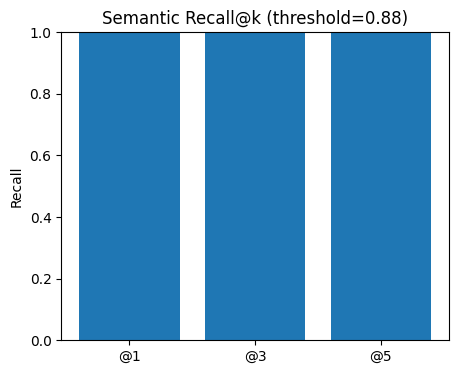

Saved: /content/drive/MyDrive/project/reports/figures/w2_retrieval_recall_plot.png


In [ ]:
# plotting Recall@k if eligible > 0
if eligible > 0:
    fig = plt.figure(figsize=(5,4))
    plt.bar(["@1","@3","@5"],
            [metrics_ret["recall@1"], metrics_ret["recall@3"], metrics_ret["recall@5"]])
    plt.ylim(0,1)
    plt.ylabel("Recall")
    plt.title(f"Semantic Recall@k (threshold={threshold})")

    out = FIG_DIR / "w2_retrieval_recall_plot.png"
    fig.savefig(out, dpi=160, bbox_inches="tight")
    plt.show()
    print("Saved:", out)
else:
    print("\nNo semantic duplicates found → skipping recall plot.")


# GEN AI Explanation without web evidence

In [ ]:
!pip -q install transformers sentencepiece

import json
import numpy as np
import pandas as pd
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

DRIVE_ROOT = Path("/content/drive/MyDrive")
DATA_DIR   = DRIVE_ROOT / "Capstone Dataset"
PROJ_DIR   = DRIVE_ROOT / "project"
TAB_DIR  = PROJ_DIR / "reports" / "tables"
OUT_DIR  = PROJ_DIR / "reports" / "tables"
OUT_DIR.mkdir(parents=True, exist_ok=True)


# loading test set + retrieval results
test_df = pd.read_csv(TAB_DIR / "split_test.csv")
ret_df  = pd.read_csv(TAB_DIR / "retrieval_results.csv")

In [ ]:
# group retrieval results by test_idx
grouped = ret_df.groupby("test_idx")

In [ ]:
# generating explanations for a subset of test claims
N_EXAMPLES = 100

# loading a small seq2seq model for explanations (FLAN-T5)
exp_model_name = "google/flan-t5-base"
exp_tokenizer  = AutoTokenizer.from_pretrained(exp_model_name)
exp_model      = AutoModelForSeq2SeqLM.from_pretrained(exp_model_name)

generator = pipeline(
    "text2text-generation",
    model=exp_model,
    tokenizer=exp_tokenizer,
    max_length=128,
    truncation=True
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# building prompts + generate explanations
rows = []

for idx in range(min(N_EXAMPLES, len(test_df))):
    row = test_df.iloc[idx]
    t_claim = row["claim"]
    true_label = row["normalised_rating"]

    # get top-k retrieved evidence for this test_idx
    if idx not in grouped.groups:
        continue
    evid = grouped.get_group(idx).sort_values("rank").head(3)

    evidence_lines = []
    for _, e in evid.iterrows():
        evidence_lines.append(
            f"- {e['retr_claim']} (Rated: {e['retr_label']}, Year: {e['retr_year']})"
        )
    evidence_text = "\n".join(evidence_lines)

    prompt = (
        "You are a fact-checking assistant.\n"
        f"Claim: {t_claim}\n"
        f"Known verdict for this claim: {true_label}\n\n"
        "Relevant past fact-checks:\n"
        f"{evidence_text}\n\n"
        "In 2-3 sentences, explain why the verdict is correct, using the evidence above. "
        "Do not invent new facts; just summarise the reasoning."
    )

    result = generator(prompt, num_return_sequences=1)[0]["generated_text"]

    rows.append({
        "test_idx": idx,
        "claim": t_claim,
        "true_label": true_label,
        "evidence": evidence_text,
        "explanation": result
    })

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
exp_df = pd.DataFrame(rows)
exp_path = OUT_DIR / "w3_explanations_sample.csv"
exp_df.to_csv(exp_path, index=False)

print("Saved sample explanations to:", exp_path)
exp_df.head()

Saved sample explanations to: /content/drive/MyDrive/project/reports/tables/w3_explanations_sample.csv


,test_idx,claim,true_label,evidence,explanation
0,0,A viral picture alleges that Sonia Gandhi and ...,Partially True,- Recent photo of BJP leader Jyotiraditya Scin...,A viral picture of Sonia Gandhi and Rajiv Gand...
1,1,"Under New York's Clean Slate Act ""violent crim...",Partially True,"- ""Violent crimes where a firearm is used have...",Violent crimes will now be automatically seale...
2,2,"11,000 politicians in New Zealand exempted fro...",Partially True,- New Zealand Government can force citizens to...,Covid is a viral disease that can be transmitt...
3,3,"Medical practitioners, fact checkers and journ...",Other,- Top fact-checkers from Asia share personal s...,You are a fact-checking assistant.
4,4,Six false assertions about Nigerian universities,Other,- FACTSHEET: Nigeria's matriculation results b...,Nigerian presidential candidate Bola Tinubu cl...


In [ ]:
exp_df.sample(5)

,test_idx,claim,true_label,evidence,explanation
4,4,Six false assertions about Nigerian universities,Other,- FACTSHEET: Nigeria's matriculation results b...,Nigerian presidential candidate Bola Tinubu cl...
89,89,A video shows a massive wave from the January ...,False,- The video shows how a ship crashed into a gi...,A video shows how a ship crashed into a giant ...
51,51,Holding a car's key fob to your head increases...,True,- Too many keys hanging from your keychain can...,Holding a car's key fob to your head increases...
33,33,The operations of National Geographic and othe...,False,- The International Space Stations was briefly...,National Geographic and other related network ...
98,98,Tata Group chairman Ratan Tata provided the In...,Partially True,"- Claim:Ratan Tata: ""In a country, if Prime Mi...",Ratan Tata has pledged his entire wealth to ri...


In [ ]:
exp_df[exp_df['true_label']=='True']

,test_idx,claim,true_label,evidence,explanation
51,51,Holding a car's key fob to your head increases...,True,- Too many keys hanging from your keychain can...,Holding a car's key fob to your head increases...
60,60,A photo authentically depicts Donald Trump wit...,True,- A photograph shows Eric and Donald Trump Jr....,Donald Trump and Ivanka Trump are the sons of ...
87,87,Giraffes have the same number of neck bones as...,True,- Image showing two giraffes up on a tree (Rat...,Giraffes have the same number of neck bones as...
99,99,"Donald Trump ""deported less, believe it or not...",True,"- Says Barack Obama ""has deported more people ...","Donald Trump ""deported more people than any ot..."


# GEN AI Explanation + Wikipedia (DuckDuckGo fallback) (with web evidence)

In [ ]:
!pip -q install openai requests transformers sentencepiece scikit-learn

import os, json, re, requests, getpass
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from openai import OpenAI
from sklearn.metrics import accuracy_score

DRIVE_ROOT = Path("/content/drive/MyDrive")
DATA_DIR   = DRIVE_ROOT / "Capstone Dataset"
PROJ_DIR   = DRIVE_ROOT / "project"
TAB_DIR  = PROJ_DIR / "reports" / "tables"
OUT_DIR  = PROJ_DIR / "reports" / "tables"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# loading test set + retrieval table
test_df = pd.read_csv(TAB_DIR / "split_test.csv")
ret_df  = pd.read_csv(TAB_DIR / "retrieval_results.csv")
grouped = ret_df.groupby("test_idx")

In [ ]:
N_EXAMPLES      = 50
TOP_K_FACTORS   = 3
TOP_K_WIKI      = 2

In [ ]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")
print("API key securely stored in environment variable.")


client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

Enter your OpenAI API key: ··········
API key securely stored in environment variable.


In [ ]:
# Web Evidence Helpers (Wikipedia + DuckDuckGo fallback)
def fetch_wikipedia_snippets(query: str, max_snippets: int = 2):
    """Fetch short snippets from Wikipedia search."""
    try:
        url = "https://en.wikipedia.org/w/api.php"
        params = {
            "action": "query",
            "list": "search",
            "srsearch": query,
            "utf8": 1,
            "format": "json",
            "srlimit": max_snippets
        }
        headers = {
            "User-Agent": "UMBC-DS-Misinformation-Project/1.0 (mailto:your_email@example.com)"
        }
        r = requests.get(url, params=params, headers=headers, timeout=10)
        r.raise_for_status()
        data = r.json()
        results = data.get("query", {}).get("search", [])
        snippets = []
        for res in results[:max_snippets]:
            title = res.get("title", "")
            snippet = res.get("snippet", "").replace(
                '<span class="searchmatch">', ""
            ).replace("</span>", "")
            snippets.append(f"{title}: {snippet}")
        return snippets
    except Exception as e:
        print("Wikipedia error:", e)
        return []


def fetch_duckduckgo_snippets(query: str, max_snippets: int = 2):
    """Fallback: DuckDuckGo instant answers."""
    try:
        url = "https://api.duckduckgo.com/"
        params = {
            "q": query,
            "format": "json",
            "no_html": 1,
            "skip_disambig": 1
        }
        r = requests.get(url, params=params, timeout=10)
        r.raise_for_status()
        data = r.json()
        snippets = []
        if "RelatedTopics" in data:
            for item in data["RelatedTopics"]:
                if "Text" in item:
                    snippets.append(item["Text"])
                if len(snippets) >= max_snippets:
                    break
        return snippets
    except Exception as e:
        print("DuckDuckGo error:", e)
        return []


def get_web_evidence(query: str, max_snippets: int = 2):
    """Try Wikipedia first, then fall back to DuckDuckGo."""
    wiki = fetch_wikipedia_snippets(query, max_snippets=max_snippets)
    if wiki:
        return wiki, "wikipedia"
    ddg = fetch_duckduckgo_snippets(query, max_snippets=max_snippets)
    return ddg, "duckduckgo" if ddg else "none"

In [ ]:
# NLI model for attribution checking
# using roberta-large-mnli for sentence-level support checking
nli_model_name = "roberta-large-mnli"
nli_tokenizer  = AutoTokenizer.from_pretrained(nli_model_name)
nli_model      = AutoModelForSequenceClassification.from_pretrained(nli_model_name)
nli_model.eval()
nli_model.to("cuda" if torch.cuda.is_available() else "cpu")
nli_device = next(nli_model.parameters()).device

def nli_entails(premise: str, hypothesis: str) -> bool:
    """Return True if premise entails hypothesis."""
    if not premise.strip() or not hypothesis.strip():
        return False
    enc = nli_tokenizer(
        premise, hypothesis,
        return_tensors="pt",
        truncation=True,
        padding="longest",
        max_length=256
    ).to(nli_device)
    with torch.no_grad():
        logits = nli_model(**enc).logits
    probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
    # NLI labels: 0=contradiction, 1=neutral, 2=entailment
    entail_prob = probs[2]
    return entail_prob >= 0.5


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# LLM explanation with citations
def generate_explanation_with_citations(claim, true_label, factors_evidence, web_evidence):
    """
    Generate explanation that uses explicit citations:
    - FACTors evidence tagged [F1], [F2], ...
    - Web evidence tagged [W1], [W2], ...
    """
    factors_lines = []
    for i, e in enumerate(factors_evidence, start=1):
        factors_lines.append(
            f"[F{i}] {e['retr_claim']} (Verdict: {e['retr_label']}, Year: {e['retr_year']})"
        )
    factors_block = "\n".join(factors_lines) or "None."

    web_lines = []
    for i, s in enumerate(web_evidence, start=1):
        web_lines.append(f"[W{i}] {s}")
    web_block = "\n".join(web_lines) or "None."

    system_prompt = (
        "You are a cautious fact-checking assistant. "
        "You must not invent facts. Only use the given evidence. "
        "If evidence is weak or missing, say that clearly."
    )

    user_prompt = f"""
Claim: {claim}
Gold verdict for this claim: {true_label}

Evidence from past fact-checks (FACTors dataset):
{factors_block}

Evidence from the web (Wikipedia/DuckDuckGo):
{web_block}

Instructions:
1. Write 2–3 sentences explaining why the given verdict is reasonable,
   or why the evidence is insufficient.
2. When you use a specific piece of evidence, cite it as [F1], [F2], [W1], etc.
3. Do NOT add new external facts; rely only on [F*] and [W*] evidence above.
4. If evidence is unclear or contradictory, mention that explicitly.
"""

    resp = client.chat.completions.create(
        model="gpt-4o-mini",   # choose the model
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user",   "content": user_prompt}
        ],
        temperature=0.3,
        max_tokens=220,
    )
    return resp.choices[0].message.content.strip()

In [ ]:
# main loop: generating explanations + attribution score
rows = []

for idx in range(min(N_EXAMPLES, len(test_df))):
    row = test_df.iloc[idx]
    t_claim = row["claim"]
    t_label = row["normalised_rating"]

    # FACTors evidence for this test_idx
    if idx in grouped.groups:
        evid_df = grouped.get_group(idx).sort_values("rank").head(TOP_K_FACTORS)
        factors_ev = [
            {
                "retr_claim": r["retr_claim"],
                "retr_label": r["retr_label"],
                "retr_year":  int(r["retr_year"]),
            }
            for _, r in evid_df.iterrows()
        ]
        factors_texts = [e["retr_claim"] for e in factors_ev]
    else:
        factors_ev = []
        factors_texts = []

    # web evidence (Wiki + DuckDuckGo fallback)
    web_ev, source_name = get_web_evidence(t_claim, max_snippets=TOP_K_WIKI)

    # generating LLM explanation with citations
    explanation = generate_explanation_with_citations(
        claim=t_claim,
        true_label=t_label,
        factors_evidence=factors_ev,
        web_evidence=web_ev
    )

    # NLI attribution support rate (FACTors + web as premises)
    evidence_snippets = factors_texts + web_ev

    rows.append({
        "test_idx": idx,
        "claim": t_claim,
        "true_label": t_label,
        "factors_evidence": json.dumps(factors_ev, ensure_ascii=False),
        "web_evidence": json.dumps(web_ev, ensure_ascii=False),
        "web_source": source_name,
        "explanation": explanation
    })


In [ ]:
exp_df = pd.DataFrame(rows)
out_path = OUT_DIR / "w3_explanations_with_web_and_nli.csv"
exp_df.to_csv(out_path, index=False)

print("Saved:", out_path)
exp_df.head()

Saved: /content/drive/MyDrive/project/reports/tables/w3_explanations_with_web_and_nli.csv


,test_idx,claim,true_label,factors_evidence,web_evidence,web_source,explanation
0,0,A viral picture alleges that Sonia Gandhi and ...,Partially True,"[{""retr_claim"": ""Recent photo of BJP leader Jy...","[""Jawaharlal Nehru: Nehru, Rajiv Gandhi: Rajin...",wikipedia,The claim that Sonia Gandhi and Rajiv Gandhi g...
1,1,"Under New York's Clean Slate Act ""violent crim...",Partially True,"[{""retr_claim"": ""\""Violent crimes where a fire...",[],none,The claim that under New York's Clean Slate Ac...
2,2,"11,000 politicians in New Zealand exempted fro...",Partially True,"[{""retr_claim"": ""New Zealand Government can fo...","[""COVID-19 pandemic in Australia: occurred in ...",wikipedia,"The claim that 11,000 politicians in New Zeala..."
3,3,"Medical practitioners, fact checkers and journ...",Other,"[{""retr_claim"": ""Top fact-checkers from Asia s...","[""List of fake news websites: satirical or new...",wikipedia,"The claim that medical practitioners, fact che..."
4,4,Six false assertions about Nigerian universities,Other,"[{""retr_claim"": ""FACTSHEET: Nigeria's matricul...","[""False or misleading statements by Donald Tru...",wikipedia,"The claim regarding ""six false assertions abou..."


In [ ]:
exp_df.sample(5)

,test_idx,claim,true_label,factors_evidence,web_evidence,web_source,explanation
38,38,108 feet Shivalinga is ready in Sri Lanka. Thi...,False,"[{""retr_claim"": ""World's largest Shivalinga at...",[],none,The claim that a 108-foot Shivalinga is ready ...
9,9,De-oligarchization of Ivanishvili or Granting ...,Partially True,"[{""retr_claim"": ""Disinformation about Saakashv...",[],none,The claim regarding MP Samadashvili's views on...
3,3,"Medical practitioners, fact checkers and journ...",Other,"[{""retr_claim"": ""Top fact-checkers from Asia s...","[""List of fake news websites: satirical or new...",wikipedia,"The claim that medical practitioners, fact che..."
23,23,Did an Indian-Origin Man Molest Air Hostess In...,Partially True,"[{""retr_claim"": ""Did 125 Pessengers of Air Ind...",[],none,The claim regarding an Indian-origin man moles...
43,43,Congress put Sonia Gandhi's image on QR code a...,False,"[{""retr_claim"": ""Image Shows Rahul Gandhi, Not...",[],none,The claim that Congress put Sonia Gandhi's ima...


# Fairness & Temporal Evaluation

In [ ]:
!pip -q install transformers scikit-learn sentencepiece

import json
import numpy as np
import pandas as pd
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score
)

DRIVE_ROOT = Path("/content/drive/MyDrive")
DATA_DIR   = DRIVE_ROOT / "Capstone Dataset"
PROJ_DIR   = DRIVE_ROOT / "project"
TAB_DIR  = PROJ_DIR / "reports" / "tables"
ART_DIR  = PROJ_DIR / "models" / "artifacts"
CKPT_DIR = PROJ_DIR / "models" / "checkpoints" / "deberta_v3_final"
MODEL_DIR = CKPT_DIR / "final_model"

In [ ]:
# loading test + mappings
test_df = pd.read_csv(TAB_DIR / "split_test.csv")

with open(ART_DIR / "label_mapping.json") as f:
    mm = json.load(f)
label2id = mm["label2id"]
id2label = {int(k): v for k,v in mm["id2label"].items()}
num_labels = len(label2id)

with open(ART_DIR / "year_mapping.json") as f:
    ym = json.load(f)
year2id = {int(k): int(v) for k,v in ym["year2id"].items()}
num_year_ids = len(year2id)

def map_year(y):
    yi = int(y)
    if yi in year2id:
        return year2id[yi]
    return max(year2id.values())

test_df["year_id"] = test_df["year"].apply(map_year)

In [ ]:
test_df.sample(5)

,year,claim,normalised_rating,label_id,split,year_id
15065,2024,Tracnews on Facebook shared a video of the Oba...,False,0,test,28
8978,2024,Video shows fake passports and Aadhaar cards b...,False,0,test,28
20872,2025,Hypertrophic Cardiomyopathy is the leading cau...,Unverifiable,4,test,28
6315,2024,"No, Illegal Immigrants Aren't Being Sent To Wi...",False,0,test,28
11322,2024,YSRCP Workers Attacked Police Officer in Andhr...,False,0,test,28


In [ ]:
# dataset
class ClaimsDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.texts = df["claim"].tolist()
        self.labels = df["label_id"].tolist()
        self.year_ids = df["year_id"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(int(self.labels[idx]), dtype=torch.long),
            "year_id": torch.tensor(int(self.year_ids[idx]), dtype=torch.long),
        }

In [ ]:
model_name = "microsoft/deberta-v3-base"
tokenizer  = AutoTokenizer.from_pretrained(MODEL_DIR)

MAX_LEN   = 256
BATCHSIZE = 32
test_dataset = ClaimsDataset(test_df, tokenizer, MAX_LEN)
test_loader  = DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)

The tokenizer you are loading from '/content/drive/MyDrive/project/models/checkpoints/deberta_v3_final/final_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e.  This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


In [ ]:
# Model with year embedding
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = AutoModel.from_pretrained(model_name)
encoder = encoder.float().to(device)
hidden_size = encoder.config.hidden_size

class DebertaWithYear(nn.Module):
    def __init__(self, encoder, num_labels, num_year_ids, year_emb_dim=32):
        super().__init__()
        self.encoder = encoder
        self.year_emb = nn.Embedding(num_year_ids, year_emb_dim)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_size + year_emb_dim, num_labels)

    def forward(self, input_ids, attention_mask, year_id):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]
        yemb = self.year_emb(year_id)
        combined = torch.cat([cls, yemb], dim=1)
        combined = self.dropout(combined)
        logits = self.classifier(combined)
        return logits

model = DebertaWithYear(
    encoder=encoder,
    num_labels=num_labels,
    num_year_ids=num_year_ids,
    year_emb_dim=32
).to(device)

state_dict = torch.load(MODEL_DIR / "pytorch_model.bin", map_location=device)
model.load_state_dict(state_dict)
model.eval()

DebertaWithYear(
  (encoder): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# getting predictions for all test samples
all_logits = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        ids  = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        yid  = batch["year_id"].to(device)
        lbls = batch["labels"].to(device)

        logits = model(ids, mask, yid)
        all_logits.append(logits.cpu().numpy())
        all_labels.append(lbls.cpu().numpy())

all_logits = np.concatenate(all_logits)
all_labels = np.concatenate(all_labels)
all_preds  = all_logits.argmax(axis=-1)

test_df["pred_label_id"] = all_preds
test_df["true_label_id"] = all_labels

In [ ]:
test_df.sample(10)

,year,claim,normalised_rating,label_id,split,year_id,pred_label_id,true_label_id
10836,2024,"A man dressed in a dark outfit, claiming that ...",False,0,test,28,0,0
13682,2024,Donald Trump opposing lockdowns and mandates f...,False,0,test,28,0,0
657,2024,Boakai is now purchasing a 1 million USD home ...,Partially True,2,test,28,2,2
116,2024,Does This Video Show BJP Leader Shreyasi Singh...,False,0,test,28,0,0
6840,2024,Personal Independence Payments are thousands o...,False,0,test,28,0,0
4386,2024,The mumps virus causes permanent hearing loss ...,Partially True,2,test,28,0,2
16393,2024,"A viral video, accompanied by an audio message...",Partially True,2,test,28,0,2
254,2024,Country singer Garth Brooks is quitting his mu...,False,0,test,28,0,0
18119,2024,"""John Dramani Mahama 500GHS Campaign's Funds F...",False,0,test,28,0,0
17345,2024,This video shows 2024's Diwali celebrations in...,Partially True,2,test,28,2,2


In [ ]:
# Per-year metrics
year_metrics = []

for year, group in test_df.groupby("year"):
    y_true = group["true_label_id"].to_numpy()
    y_pred = group["pred_label_id"].to_numpy()

    if len(np.unique(y_true)) < 2:
        # skipping years with only one class (macro F1 undefined)
        continue

    acc  = accuracy_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred, average="macro")
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_true, y_pred, average="macro", zero_division=0)

    year_metrics.append({
        "year": year,
        "n_samples": len(group),
        "accuracy": acc,
        "macro_f1": f1,
        "macro_precision": prec,
        "macro_recall": rec
    })

year_metrics_df = pd.DataFrame(year_metrics).sort_values("year")
out_path = TAB_DIR / "w3_temporal_metrics_by_year.csv"

In [ ]:
print(year_metrics_df)
year_metrics_df.to_csv(out_path, index=False)

print("Saved per-year metrics to:", out_path)

   year  n_samples  accuracy  macro_f1  macro_precision  macro_recall
0  2024      20546  0.655602  0.352722         0.357708      0.372019
1  2025        338  0.680473  0.333173         0.388522      0.348973
Saved per-year metrics to: /content/drive/MyDrive/project/reports/tables/w3_temporal_metrics_by_year.csv


# Packaging & FastAPI

In [ ]:
!pip install faiss-cpu --no-cache-dir
!pip install faiss-gpu --no-cache-dir

ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu


In [ ]:
!pip -q install fastapi uvicorn openai sentence-transformers requests transformers

import json, requests, re
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List

import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer
import faiss

from fastapi import FastAPI
from pydantic import BaseModel
from openai import OpenAI

DRIVE_ROOT = Path("/content/drive/MyDrive")
DATA_DIR   = DRIVE_ROOT / "Capstone Dataset"
PROJ_DIR   = DRIVE_ROOT / "project"
TAB_DIR  = PROJ_DIR / "reports" / "tables"
ART_DIR  = PROJ_DIR / "models" / "artifacts"
CKPT_DIR = PROJ_DIR / "models" / "checkpoints" / "deberta_v3_final"
MODEL_DIR = CKPT_DIR / "final_model"

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")
print("API key securely stored in environment variable.")


client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# loading mappings
with open(ART_DIR / "label_mapping.json") as f:
    mm = json.load(f)
label2id = mm["label2id"]
id2label = {int(k): v for k,v in mm["id2label"].items()}
num_labels = len(label2id)

with open(ART_DIR / "year_mapping.json") as f:
    ym = json.load(f)
year2id = {int(k): int(v) for k,v in ym["year2id"].items()}
num_year_ids = len(year2id)

def map_year_input(year: int) -> int:
    yi = int(year)
    if yi in year2id:
        return year2id[yi]
    return max(year2id.values())

# classification model
base_model_name = "microsoft/deberta-v3-base"
clf_tokenizer   = AutoTokenizer.from_pretrained(MODEL_DIR)
encoder         = AutoModel.from_pretrained(base_model_name).float().to(device)
hidden_size     = encoder.config.hidden_size

class DebertaWithYear(nn.Module):
    def __init__(self, encoder, num_labels, num_year_ids, year_emb_dim=32):
        super().__init__()
        self.encoder = encoder
        self.year_emb = nn.Embedding(num_year_ids, year_emb_dim)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_size + year_emb_dim, num_labels)

    def forward(self, input_ids, attention_mask, year_id):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]
        yemb = self.year_emb(year_id)
        combined = torch.cat([cls, yemb], dim=1)
        combined = self.dropout(combined)
        logits = self.classifier(combined)
        return logits

clf_model = DebertaWithYear(
    encoder=encoder,
    num_labels=num_labels,
    num_year_ids=num_year_ids,
    year_emb_dim=32
).to(device)

state_dict = torch.load(MODEL_DIR / "pytorch_model.bin", map_location=device)
clf_model.load_state_dict(state_dict)
clf_model.eval()

# retrieval index
train_df = pd.read_csv(TAB_DIR / "split_train.csv")
train_texts = train_df["claim"].astype(str).tolist()

sbert = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
train_embs = sbert.encode(train_texts, show_progress_bar=False,
                          convert_to_numpy=True, normalize_embeddings=True)
dim = train_embs.shape[1]
faiss_index = faiss.IndexFlatIP(dim)
faiss_index.add(train_embs)

def retrieve_similar_claims(claim: str, k: int = 3):
    emb = sbert.encode([claim], convert_to_numpy=True, normalize_embeddings=True)
    D, I = faiss_index.search(emb, k)
    out = []
    for rank, (idx, score) in enumerate(zip(I[0], D[0]), start=1):
        row = train_df.iloc[idx]
        out.append({
            "rank": rank,
            "similarity": float(score),
            "claim": row["claim"],
            "label": row["normalised_rating"],
            "year": int(row["year"])
        })
    return out

# web evidence: Wikipedia + DuckDuckGo
def fetch_wikipedia_snippets(query: str, max_snippets: int = 2):
    try:
        url = "https://en.wikipedia.org/w/api.php"
        params = {
            "action": "query",
            "list": "search",
            "srsearch": query,
            "utf8": 1,
            "format": "json",
            "srlimit": max_snippets
        }
        headers = {
            "User-Agent": "UMBC-DS-Misinformation-Project/1.0 (mailto:your_email@example.com)"
        }
        r = requests.get(url, params=params, headers=headers, timeout=10)
        r.raise_for_status()
        data = r.json()
        results = data.get("query", {}).get("search", [])
        snippets = []
        for res in results[:max_snippets]:
            title = res.get("title", "")
            snippet = res.get("snippet", "").replace(
                '<span class="searchmatch">', ""
            ).replace("</span>", "")
            snippets.append(f"{title}: {snippet}")
        return snippets
    except Exception as e:
        print("Wikipedia error:", e)
        return []

def fetch_duckduckgo_snippets(query: str, max_snippets: int = 2):
    try:
        url = "https://api.duckduckgo.com/"
        params = {
            "q": query,
            "format": "json",
            "no_html": 1,
            "skip_disambig": 1
        }
        r = requests.get(url, params=params, timeout=10)
        r.raise_for_status()
        data = r.json()
        snippets = []
        if "RelatedTopics" in data:
            for item in data["RelatedTopics"]:
                if "Text" in item:
                    snippets.append(item["Text"])
                if len(snippets) >= max_snippets:
                    break
        return snippets
    except Exception as e:
        print("DuckDuckGo error:", e)
        return []

def get_web_evidence(query: str, max_snippets: int = 2):
    wiki = fetch_wikipedia_snippets(query, max_snippets=max_snippets)
    if wiki:
        return wiki, "wikipedia"
    ddg = fetch_duckduckgo_snippets(query, max_snippets=max_snippets)
    return ddg, ("duckduckgo" if ddg else "none")

# NLI for attribution
nli_model_name = "roberta-large-mnli"
nli_tokenizer  = AutoTokenizer.from_pretrained(nli_model_name)
nli_model      = AutoModelForSequenceClassification.from_pretrained(nli_model_name)
nli_model.to(device)
nli_model.eval()

def nli_entails(premise: str, hypothesis: str) -> bool:
    if not premise.strip() or not hypothesis.strip():
        return False
    enc = nli_tokenizer(
        premise, hypothesis,
        return_tensors="pt",
        truncation=True,
        padding="longest",
        max_length=256
    ).to(device)
    with torch.no_grad():
        logits = nli_model(**enc).logits
    probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
    # label 2 = ENTAILMENT
    return probs[2] >= 0.5

def compute_attribution_support_rate(explanation: str, evidence_snippets: list[str]) -> float:
    sent_candidates = re.split(r'[.!?]\s+', explanation.strip())
    sentences = [s.strip() for s in sent_candidates if len(s.strip()) > 0]
    if not sentences or not evidence_snippets:
        return 0.0
    supported = 0
    for sent in sentences:
        entailed = any(nli_entails(ev, sent) for ev in evidence_snippets)
        if entailed:
            supported += 1
    return supported / len(sentences)

# classification helper
def classify_claim(claim: str, year: int):
    year_id = map_year_input(year)
    enc = clf_tokenizer(
        claim,
        truncation=True,
        padding="max_length",
        max_length=256,
        return_tensors="pt"
    )
    input_ids = enc["input_ids"].to(device)
    mask      = enc["attention_mask"].to(device)
    yid       = torch.tensor([year_id], dtype=torch.long).to(device)
    with torch.no_grad():
        logits = clf_model(input_ids, mask, yid)
        probs  = torch.softmax(logits, dim=-1).cpu().numpy()[0]
        pred_id = int(probs.argmax())
        pred_label = id2label[pred_id]
    return pred_label, probs

# LLM explanation with citations
def generate_explanation(claim: str, year: int, pred_label: str, factors_evidence, web_evidence):
    factors_lines = []
    for i, e in enumerate(factors_evidence, start=1):
        factors_lines.append(f"[F{i}] {e['claim']} (Verdict: {e['label']}, Year: {e['year']})")
    factors_block = "\n".join(factors_lines) or "None."

    web_lines = []
    for i, s in enumerate(web_evidence, start=1):
        web_lines.append(f"[W{i}] {s}")
    web_block = "\n".join(web_lines) or "None."

    system_prompt = (
        "You are a cautious fact-checking assistant. "
        "Use ONLY the evidence provided. No outside knowledge. "
        "If evidence is weak, say that clearly."
    )
    user_prompt = f"""
Claim: {claim}
Year: {year}
Model's predicted verdict: {pred_label}

Evidence from past fact-checks (FACTors dataset):
{factors_block}

Evidence from the web:
{web_block}

Instructions:
1. Write 2–3 sentences explaining why this verdict may be reasonable
   based on the [F*] and [W*] evidence.
2. Cite evidence with [F1], [F2], [W1], etc.
3. If there is not enough evidence, say that explicitly.
"""

    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user",   "content": user_prompt}
        ],
        temperature=0.3,
        max_tokens=220,
    )
    return resp.choices[0].message.content.strip()

# confidence scoring
def compute_confidence(probs, factors_evidence, web_evidence):
    clf_conf = float(probs.max())
    if factors_evidence:
        avg_sim = float(np.mean([e["similarity"] for e in factors_evidence]))
    else:
        avg_sim = 0.0
    web_conf = min(1.0, len(web_evidence) / 3.0)
    # simple weighted combination
    overall = 0.5 * clf_conf + 0.3 * avg_sim + 0.2 * web_conf
    return {
        "classifier_confidence": clf_conf,
        "retrieval_confidence": avg_sim,
        "web_confidence": web_conf,
        "overall_confidence": overall,
    }




Enter your OpenAI API key: ··········
API key securely stored in environment variable.


The tokenizer you are loading from '/content/drive/MyDrive/project/models/checkpoints/deberta_v3_final/final_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a

# Running API

In [ ]:
# FastAPI app
app = FastAPI(title="Misinformation Detector + Fact-Checking Agent (Web + FACTors + NLI)")

class AnalyzeRequest(BaseModel):
    claim: str
    year: int

@app.get("/health")
def health():
    return {"status": "ok"}

@app.post("/analyze")
def analyze(req: AnalyzeRequest):
    # Classification
    pred_label, probs = classify_claim(req.claim, req.year)

    # FACTors retrieval (+ keep top3 with similarity)
    factors_ev = retrieve_similar_claims(req.claim, k=3)

    # Web evidence
    web_ev, web_source = get_web_evidence(req.claim, max_snippets=2)

    # Explanation
    explanation = generate_explanation(
        claim=req.claim,
        year=req.year,
        pred_label=pred_label,
        factors_evidence=factors_ev,
        web_evidence=web_ev
    )

    # NLI attribution
    evidence_snippets = [e["claim"] for e in factors_ev] + web_ev
    attr_rate = compute_attribution_support_rate(explanation, evidence_snippets)

    # Confidence
    conf = compute_confidence(probs, factors_ev, web_ev)

    return {
        "claim": req.claim,
        "year": req.year,
        "predicted_label": pred_label,
        "class_probabilities": {id2label[i]: float(p) for i, p in enumerate(probs)},
        "retrieved_factchecks": factors_ev,
        "web_evidence_source": web_source,
        "web_evidence": web_ev,
        "explanation": explanation,
        "attribution_support_rate": attr_rate,
        "confidence": conf
    }


In [ ]:
!pip install pyngrok fastapi uvicorn nest_asyncio > /dev/null

In [ ]:
from pyngrok import ngrok
import getpass
import nest_asyncio
import uvicorn
from threading import Thread
import logging
import requests

nest_asyncio.apply()

# getting ngrok auth token from user
NGROK_AUTH_TOKEN = getpass.getpass("Enter your ngrok auth token: ")

# registering token with ngrok
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# killing old tunnels (if rerun)
ngrok.kill()

# starting a new HTTP tunnel on port 8000
public_url = ngrok.connect(8000, "http")
print("Public URL:", public_url)

# Silence uvicorn / fastapi logs
logging.getLogger("uvicorn").setLevel(logging.CRITICAL)
logging.getLogger("uvicorn.error").setLevel(logging.CRITICAL)
logging.getLogger("uvicorn.access").setLevel(logging.CRITICAL)
logging.getLogger("fastapi").setLevel(logging.CRITICAL)

# function to run the API server ----
def run_api():
    uvicorn.run(
        app,
        host="0.0.0.0",
        port=8000,
        log_level="critical",
        access_log=False
    )

# killing previous app thread if any (best-effort, ignore errors)
try:
    api_thread.join(0.1)  # if api_thread exists, try to join briefly
except Exception:
    pass

# starting FastAPI server in a background thread
api_thread = Thread(target=run_api, daemon=True)
api_thread.start()

print("FastAPI server running at:", public_url)

# quick local health check
try:
    print("Local /health:", requests.get("http://0.0.0.0:8000/health").json())
except Exception as e:
    print("Local health check error:", e)

Enter your ngrok auth token: ··········
Public URL: NgrokTunnel: "https://unimputable-jumpily-jedidiah.ngrok-free.dev" -> "http://localhost:8000"
FastAPI server running at: NgrokTunnel: "https://unimputable-jumpily-jedidiah.ngrok-free.dev" -> "http://localhost:8000"
Local /health: {'status': 'ok'}


In [ ]:
import json
import textwrap

def pretty_print_analysis(resp: dict, wrap: int = 100):
    def wrap_text(text):
        return "\n    ".join(textwrap.wrap(text, width=wrap))

    print("=== FACT-CHECK RESULT ===")
    print(f"Claim: {resp.get('claim')}")
    print(f"Year:  {resp.get('year')}\n")

    # verdict + class probabilities
    print(f"Model verdict: {resp.get('predicted_label')}")
    probs = resp.get("class_probabilities", {})
    if probs:
        print("Top classes:")
        # sort by prob desc
        for label, prob in sorted(probs.items(), key=lambda x: x[1], reverse=True):
            print(f"  - {label:<15}: {prob:.3f}")
    print()

    # confidence
    conf = resp.get("confidence", {})
    if conf:
        print(f"Overall confidence: {conf.get('overall_confidence', 0):.2f}")
        print("  - classifier_confidence:", f"{conf.get('classifier_confidence', 0):.2f}")
        print("  - retrieval_confidence :", f"{conf.get('retrieval_confidence', 0):.2f}")
        print("  - web_confidence       :", f"{conf.get('web_confidence', 0):.2f}")
        print()

    # FACTors evidence
    facts = resp.get("retrieved_factchecks", [])
    print("Evidence from FACTors:")
    if facts:
        for i, e in enumerate(facts, start=1):
            sim = e.get("similarity", 0.0)
            print(
                f"  [F{i}] {e.get('claim')} "
                f"(Verdict: {e.get('label')}, Year: {e.get('year')})  sim={sim:.3f}"
            )
    else:
        print("  (none)")
    print()

    # web evidence
    web_src = resp.get("web_evidence_source", "unknown")
    web_ev  = resp.get("web_evidence", [])
    print(f"Evidence from the web ({web_src}):")
    if web_ev:
        for i, s in enumerate(web_ev, start=1):
            print(f"  [W{i}] {wrap_text(s)}")
    else:
        print("  (none)")
    print()

    # explanation
    expl = resp.get("explanation", "")
    print("Explanation:")
    if expl:
        print("  " + wrap_text(expl))
    else:
        print("  (none)")
    print()

    # attribution
    attr = resp.get("attribution_support_rate", None)
    if attr is not None:
        print(f"Attribution support rate (NLI): {attr:.2f}")
        if attr < 0.3:
            print("  (Low support: explanation is weakly grounded in evidence.)")
        elif attr < 0.7:
            print("  (Mixed support: some sentences are grounded, some are not.)")
        else:
            print("  (High support: explanation is strongly grounded in evidence.)")

    print("\n=== RAW JSON ===")
    print(json.dumps(resp, indent=2, ensure_ascii=False))


In [ ]:
# analyzing request
try:
    payload = {"claim": "covid-19 causes cancer", "year": 2024}
    resp = requests.post("http://0.0.0.0:8000/analyze", json=payload).json()
    pretty_print_analysis(resp)
except Exception as e:
    print("Analyze example error:", e)

=== FACT-CHECK RESULT ===
Claim: covid-19 causes cancer
Year:  2024

Model verdict: Partially True
Top classes:
  - Partially True : 0.582
  - False          : 0.418
  - True           : 0.000
  - Other          : 0.000
  - Unverifiable   : 0.000

Overall confidence: 0.65
  - classifier_confidence: 0.58
  - retrieval_confidence : 0.76
  - web_confidence       : 0.67

Evidence from FACTors:
  [F1] Covid-19 vaccines causing an increase in Cancer (Verdict: False, Year: 2022)  sim=0.828
  [F2] Uptick in cancer in 2021 is linked to Covid-19 vaccination (Verdict: False, Year: 2022)  sim=0.735
  [F3] The Covid-19 pandemic is caused by radiation (Verdict: False, Year: 2020)  sim=0.720

Evidence from the web (wikipedia):
  [W1] Turbo cancer: not supported by cancer research, and there is no evidence that COVID-19 vaccination
    causes or worsens cancer. Opponents of COVID-19 vaccines such as
  [W2] List of deaths due to COVID-19: 2019 (COVID-19) or post COVID-19 (long COVID), as a result of
  